# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


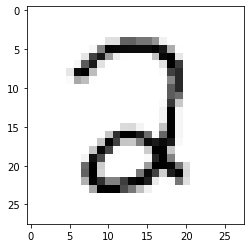

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2282
Training Accuracy: 0.7555, Testing Accuracy: 0.7702



Epoch 10, Loss 0.0801
Training Accuracy: 0.9348, Testing Accuracy: 0.9400



Epoch 20, Loss 0.0503
Training Accuracy: 0.9492, Testing Accuracy: 0.9572



Epoch 30, Loss 0.0406
Training Accuracy: 0.9567, Testing Accuracy: 0.9607



Epoch 40, Loss 0.0356
Training Accuracy: 0.9607, Testing Accuracy: 0.9637



Epoch 50, Loss 0.0325
Training Accuracy: 0.9644, Testing Accuracy: 0.9657



Epoch 60, Loss 0.0303
Training Accuracy: 0.9662, Testing Accuracy: 0.9667



Epoch 70, Loss 0.0285
Training Accuracy: 0.9682, Testing Accuracy: 0.9662



Epoch 80, Loss 0.0271
Training Accuracy: 0.9696, Testing Accuracy: 0.9662



Epoch 90, Loss 0.026
Training Accuracy: 0.9708, Testing Accuracy: 0.9677



Epoch 100, Loss 0.025
Training Accuracy: 0.9718, Testing Accuracy: 0.9688



Epoch 110, Loss 0.0241
Training Accuracy: 0.9733, Testing Accuracy: 0.9693



Epoch 120, Loss 0.0233
Training Accuracy: 0.9743, Testing Accuracy: 0.9703



Epoch 130, Loss 0.0226
Training Accuracy: 0.9755, Testing Accuracy: 0.9698



Epoch 140, Loss 0.0219
Training Accuracy: 0.9761, Testing Accuracy: 0.9688



Epoch 150, Loss 0.0213
Training Accuracy: 0.9769, Testing Accuracy: 0.9698



Epoch 160, Loss 0.0207
Training Accuracy: 0.9773, Testing Accuracy: 0.9713



Epoch 170, Loss 0.0202
Training Accuracy: 0.9775, Testing Accuracy: 0.9718



Epoch 180, Loss 0.0197
Training Accuracy: 0.9781, Testing Accuracy: 0.9728



Epoch 190, Loss 0.0192
Training Accuracy: 0.9787, Testing Accuracy: 0.9733



Epoch 200, Loss 0.0188
Training Accuracy: 0.9791, Testing Accuracy: 0.9738



Epoch 210, Loss 0.0184
Training Accuracy: 0.9797, Testing Accuracy: 0.9738



Epoch 220, Loss 0.018
Training Accuracy: 0.9805, Testing Accuracy: 0.9743



Epoch 230, Loss 0.0176
Training Accuracy: 0.9811, Testing Accuracy: 0.9743



Epoch 240, Loss 0.0172
Training Accuracy: 0.9821, Testing Accuracy: 0.9743



0.007085240687836926

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2602
Training Accuracy: 0.6031, Testing Accuracy: 0.5958



Epoch 10, Loss 0.1036
Training Accuracy: 0.9109, Testing Accuracy: 0.9264



Epoch 20, Loss 0.0793
Training Accuracy: 0.9262, Testing Accuracy: 0.9395



Epoch 30, Loss 0.0684
Training Accuracy: 0.9351, Testing Accuracy: 0.9491



Epoch 40, Loss 0.0619
Training Accuracy: 0.9402, Testing Accuracy: 0.9541



Epoch 50, Loss 0.0574
Training Accuracy: 0.9437, Testing Accuracy: 0.9556



Epoch 60, Loss 0.0541
Training Accuracy: 0.9458, Testing Accuracy: 0.9577



Epoch 70, Loss 0.0516
Training Accuracy: 0.9473, Testing Accuracy: 0.9592



Epoch 80, Loss 0.0495
Training Accuracy: 0.9488, Testing Accuracy: 0.9612



Epoch 90, Loss 0.0478
Training Accuracy: 0.9508, Testing Accuracy: 0.9627



Epoch 100, Loss 0.0464
Training Accuracy: 0.9518, Testing Accuracy: 0.9627



Epoch 110, Loss 0.0451
Training Accuracy: 0.9528, Testing Accuracy: 0.9632



Epoch 120, Loss 0.0441
Training Accuracy: 0.9537, Testing Accuracy: 0.9627



Epoch 130, Loss 0.0431
Training Accuracy: 0.9545, Testing Accuracy: 0.9627



Epoch 140, Loss 0.0423
Training Accuracy: 0.9557, Testing Accuracy: 0.9632



Epoch 150, Loss 0.0415
Training Accuracy: 0.9563, Testing Accuracy: 0.9642



Epoch 160, Loss 0.0409
Training Accuracy: 0.9570, Testing Accuracy: 0.9642



Epoch 170, Loss 0.0402
Training Accuracy: 0.9577, Testing Accuracy: 0.9647



Epoch 180, Loss 0.0397
Training Accuracy: 0.9580, Testing Accuracy: 0.9647



Epoch 190, Loss 0.0391
Training Accuracy: 0.9588, Testing Accuracy: 0.9657



Epoch 200, Loss 0.0387
Training Accuracy: 0.9590, Testing Accuracy: 0.9657



Epoch 210, Loss 0.0382
Training Accuracy: 0.9595, Testing Accuracy: 0.9657



Epoch 220, Loss 0.0378
Training Accuracy: 0.9595, Testing Accuracy: 0.9657



Epoch 230, Loss 0.0374
Training Accuracy: 0.9599, Testing Accuracy: 0.9657



Epoch 240, Loss 0.037
Training Accuracy: 0.9601, Testing Accuracy: 0.9657



0.013273837667210794

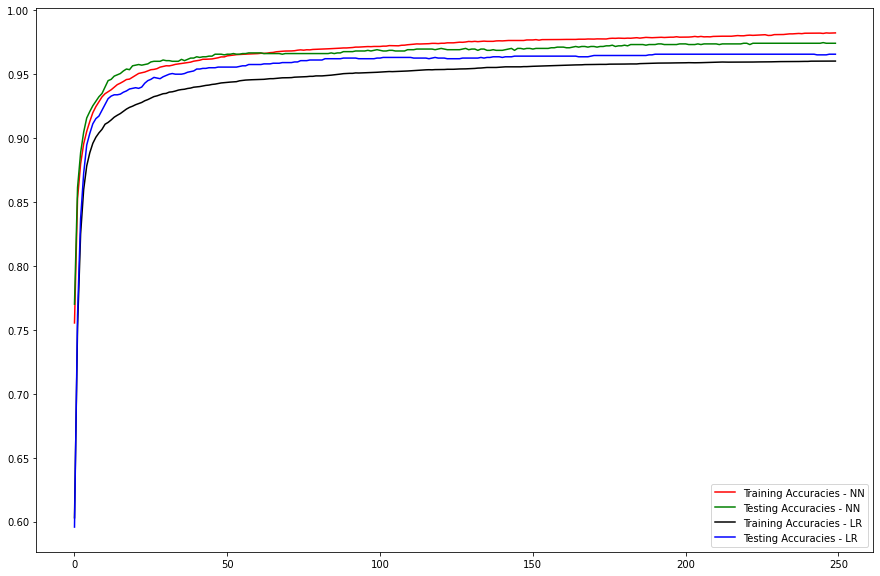

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

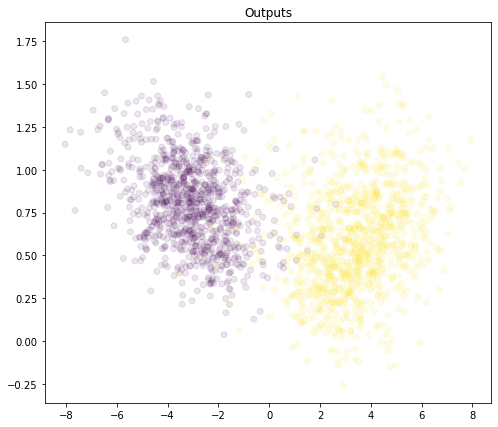

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

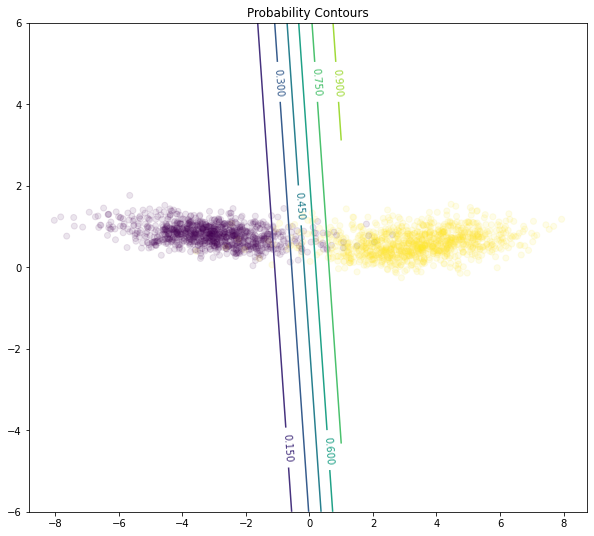

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );